## PART 1 Data Acquisition

In [40]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import re
import time

# lists to store the data
ranks = []
title_lengths = []
age_in_hours = []
points = []
comment_counts = []

# Loop through the first 5 pages
for i in range(5):
    url= "https://news.ycombinator.com/?p=" + str(i+1)
    
    # read and decode page 
    with urllib.request.urlopen (url) as response:
        html = response.read()
        html = html.decode("utf-8")
    
    # save the HTML page content
    with open ("hackernews" + str(i+1) + ".html", "w") as new_file:
        new_file.write(html)
    
    # parse the HTML content stored in html and save as 'soup'
    parsedPage = BeautifulSoup(html, 'html.parser')

    #scraping rank
    for post in parsedPage.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.','')
        ranks.append(int(rank))

    #scraping length of title
    for title in parsedPage.find_all(class_="titleline"):
        title_lengths.append(len(title.text))

    #scraping age of post
    for age  in parsedPage.find_all(class_="age"):
        age_str = str(age.text)
        age_str = age_str.removesuffix(" hours ago")
        age_str = age_str.removesuffix(" hour ago")
        
        # 1 day ago, converted to 24 hours
        if " day ago" in age_str:
            age_in_hours.append(24)
        elif " days ago" in age_str:
            modified_string = age_str.replace(" days ago", "")
            age_int = int(modified_string)
            age_in_hours.append(24*age_int)
        elif " minutes ago" in age_str:
            age_in_hours.append(0)
        elif " minute ago" in age_str:
            age_in_hours.append(0)
        else:
            age_in_hours.append(int(age_str))

    #scraping points and comments
    for subtext in parsedPage.find_all(class_="subtext" ):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            # extract the number from the text
            point = int(re.search(r'\d+', str(score.text)).group())

        for anchorTag in subtext.find_all("a"):
            if anchorTag.text.endswith("comments"):
                a_string = str(anchorTag.text)
                # extract the number from the text
                comments = int(re.search(r'\d+', a_string).group())
        comment_counts.append(int(comments))
        points.append(int(point))
    
    # avoid overloading the server    
    time.sleep(5)


# creating a data frame
submissions_df1 = pd.DataFrame({"rank": ranks, "title_lengths": title_lengths, "age_in_hours": age_in_hours, "points": points, "comment_counts": comment_counts})
print(submissions_df1)

# save as csv file
submissions_df1.to_csv('hackerPosts.csv', index=False)

     rank  title_lengths  age_in_hours  points  comment_counts
0       1             74             1      38              10
1       2             93            14     842             155
2       3             78             1      35              13
3       4             34            11     294             289
4       5             85            17     685             198
..    ...            ...           ...     ...             ...
145   146             23             8      31              17
146   147             78             2       4               0
147   148             81            48     100              70
148   149             43            48      50               4
149   150             60            48     351              93

[150 rows x 5 columns]


## Part 2 Regression

In [41]:
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

submissions_df = pd.read_csv('hackerPosts.csv')

# rank predicted by comment_counts, points, and age_in_hours
count_points_age_ols = sm.ols(formula="rank ~ comment_counts + points + age_in_hours", data=submissions_df).fit()
count_points_age_ols.summary()
print(count_points_age_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     23.59
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.66e-12
Time:                        20:27:18   Log-Likelihood:                -748.43
No. Observations:                 150   AIC:                             1505.
Df Residuals:                     146   BIC:                             1517.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         56.0769      4.475     12.

#### Rank predicted by comment_counts, points, and age_in_hours
R squared = .336
P value:
- comment_counts = .459
- points = 0.0
- age_in_hours = 0.0


In [42]:
#rank predicted by age
age_rank_ols = sm.ols(formula="rank ~ age_in_hours", data=submissions_df).fit()
age_rank_ols.summary()
print(age_rank_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     43.06
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           8.38e-10
Time:                        20:27:18   Log-Likelihood:                -758.91
No. Observations:                 150   AIC:                             1522.
Df Residuals:                     148   BIC:                             1528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       52.9960      4.645     11.410   

#### Rank predicted by age_in_hours

R-squared = .257
P value = 0.00

In [43]:
#rank predicted points + comments
rank_points_ols = sm.ols(formula="rank ~ comment_counts + points", data=submissions_df).fit()
print(str(rank_points_ols.params))
print(rank_points_ols.summary())

Intercept         77.170770
comment_counts    -0.016216
points            -0.008687
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.2016
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.818
Time:                        20:27:18   Log-Likelihood:                -777.86
No. Observations:                 150   AIC:                             1562.
Df Residuals:                     147   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

#### Rank predicted by comment_counts and points

R-squared = 0
P-value:
- comment count = .993
- points = .940

In [44]:
#rank predicted by points + age
rank_points_ols = sm.ols(formula="rank ~ points + age_in_hours", data=submissions_df).fit()
rank_points_ols.summary()
print(rank_points_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     35.45
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.73e-13
Time:                        20:27:18   Log-Likelihood:                -748.54
No. Observations:                 150   AIC:                             1503.
Df Residuals:                     147   BIC:                             1512.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       56.4063      4.410     12.790   

#### Rank predicted by points and age
R-squared = .336
P value:
- points = 0.0
- age = 0.0


#### Observations
The closer a R-square value is to 1, the stronger the correlation and the closer a P-value is to 0 the more significant the prediction is. 

Based off this, we can determine points and age together are the best indicator of rank, with their model explaining 36.6% of variability in rank. 

The coeff for points is -0.1133 and for age is 2.2187. This is note worthy because it means that as points go up, the rank will go slightly down. 




## Part 3 Classification

Optimization terminated successfully.
         Current function value: 0.420080
         Iterations 6


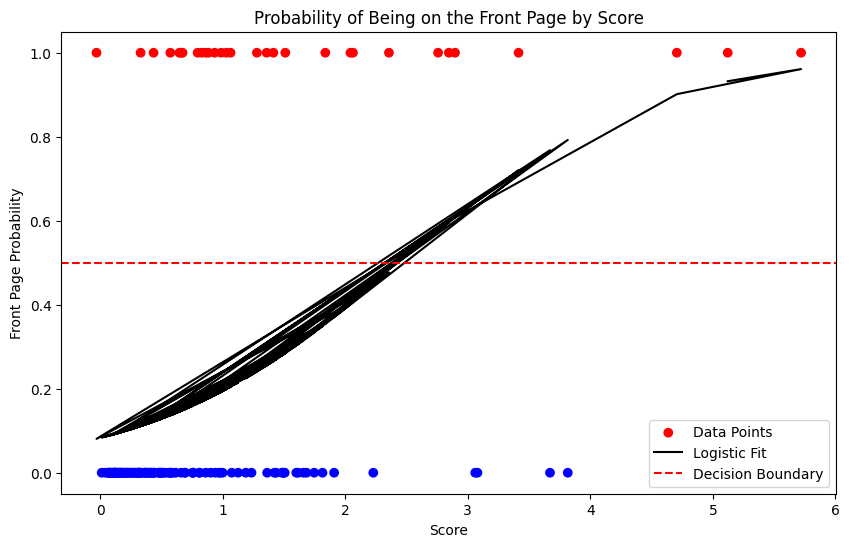

                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Jun 2024   Pseudo R-squ.:                  0.1605
Time:                        20:27:18   Log-Likelihood:                -63.012
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 9.162e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4042      0.340     -7.066      0.000      -3.071      -1.737
Score          0.9809      0.234      4.198      0.000       0.523       1.439


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Compute 'Front Page' binary variable
submissions_df['Front Page'] = np.where(submissions_df['rank'] <= 30, 1, 0)
# Add 'Score' column (post's engagement relative to its age and points)
submissions_df['Score'] = (submissions_df['points'] - 1) / (submissions_df['age_in_hours'] + 2) ** 1.8

# Logistic Regression Model
logit_model = sm.Logit(submissions_df['Front Page'], sm.add_constant(submissions_df[['Score']]))
result = logit_model.fit()

# PLOT
plt.figure(figsize=(10, 6))

# scatter plot data points are colored based on their front page status
plt.scatter(submissions_df['Score'], submissions_df['Front Page'], c=['red' if x else 'blue' for x in submissions_df['Front Page']], label='Data Points')

# logistic regression curve 
predicted_probs = result.predict(sm.add_constant(submissions_df[['Score']]))
plt.plot(submissions_df['Score'], predicted_probs, color='black', label='Logistic Fit')

# decision boundary
plt.axhline(0.5, color='red', linestyle='--', label='Decision Boundary')

plt.xlabel('Score')
plt.ylabel('Front Page Probability')
plt.title('Probability of Being on the Front Page by Score')
plt.legend()
plt.show()

# Print the summary of the logistic regression
print(result.summary())


**Pseudo R-squared (0.1257):**  The model explains about 12.57% of the variability in the front page status, which is relatively poor explanatory power.

**Log-Likelihood and LL-Null:** The log-likelihood of the model is -65.622, compared to -75.060 for the model with no predictors (LL-Null). This improvement indicates that the model with predictors fits the data significantly better than a null model.

**Score Coefficient:** 0.7793 with a standard error of 0.196. This positive coefficient indicates that higher scores significantly increase the log odds of a post being on the front page. The coefficient is statistically significant (P < 0.001), showing strong evidence that higher engagement relative to their age and points are more likely to appear on the front page.